# Perform deconvolution using Richardson-Lucy on a grayscale image

## Load data and prepare operators

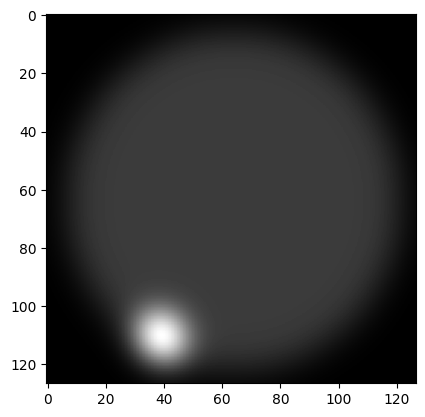

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import richardon_lucy as rl
import noise
import blur
from PIL import Image

device = "cuda"

k_size = 63
k_std = 6.0
n_std = 0.1
n_rate = 0.1

# Load the data
ref = Image.open('img/img_88.png').convert('L')

ref = torch.from_numpy(np.array(ref)).unsqueeze(0).unsqueeze(0).to(device).float() / 255.0
ref = ref[:, :, :-1, :-1]

gaussianblur = blur.GaussianBlur(k_size, k_std).to(device)
k_ref = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)

noiser = noise.PoissonNoise(n_rate)
# noiser = noise.GaussianNoise(n_std)

# Blur the image
y = gaussianblur(ref)

# Add noise
# y = noiser(y)
plt.imshow(y[0, 0].detach().cpu().numpy(), cmap='gray')

## Perform the non-blind deconvolution

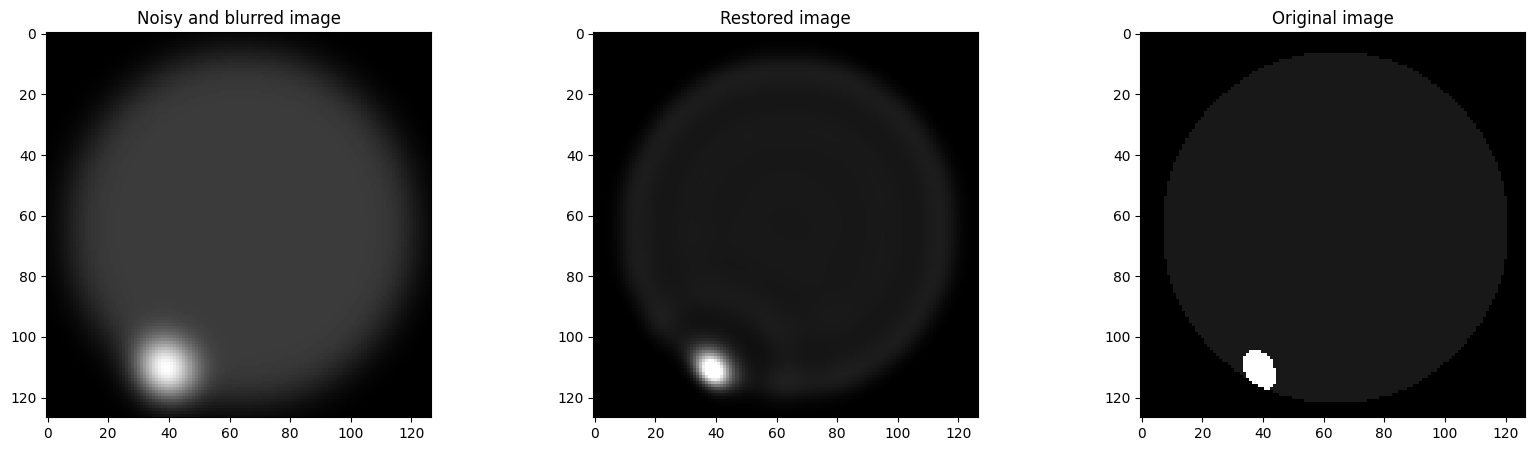

In [38]:
x_0 = torch.ones_like(y) 

res = rl.richardson_lucy(y, x_0, k_ref, steps=50, clip=True, filter_epsilon=1e-6)

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.imshow(y[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Noisy and blurred image')
plt.subplot(1, 3, 2)
plt.imshow(res[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Restored image')
plt.subplot(1, 3, 3)
plt.imshow(ref[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Original image')
plt.show()

## Perform the blind deconvolution 

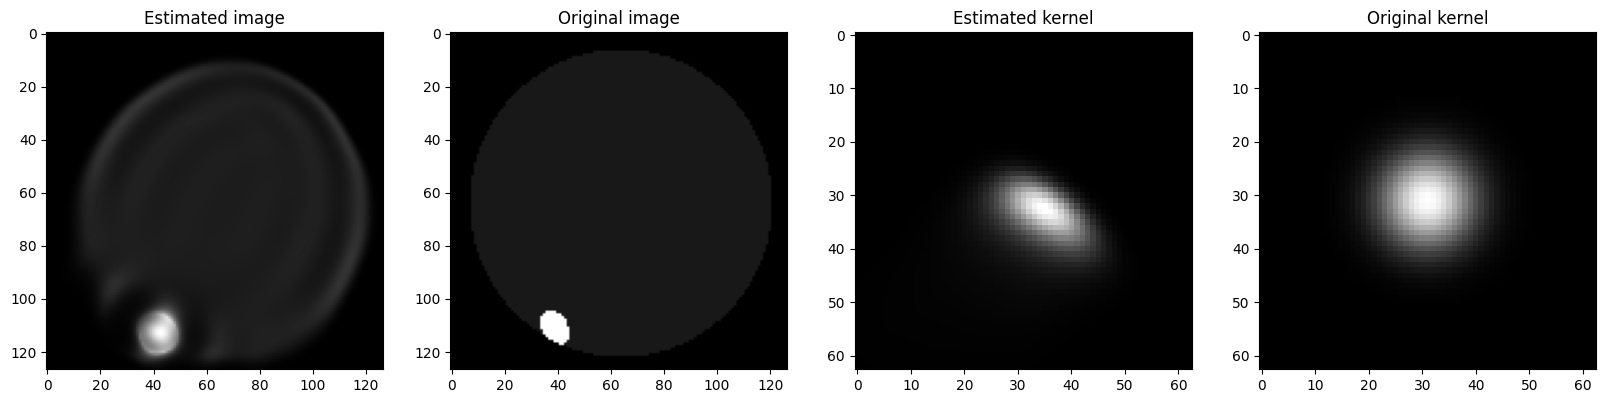

In [41]:
# Different initializations for the image
# x_0 = torch.ones_like(y)
x_0 = y


# Different initializations for the kernel
gaussianblur = blur.GaussianBlur(k_size, 6.0).to(device)

# k_0 = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)
k_0 = torch.ones_like(k_ref) / torch.sum(torch.ones_like(k))
# k_0 = k

steps = 200
k_steps = 1
x_steps = 1

filter_epsilon = 1e-12
clip = True
observation = y

img_res, k_res = rl.blind_richardson_lucy(observation, x_0, k_0, steps=steps, x_steps=x_steps, k_steps=k_steps, clip=clip, filter_epsilon=filter_epsilon)


plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(img_res[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Estimated image')
plt.subplot(1, 4, 2)
plt.imshow(ref[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Original image')
plt.subplot(1, 4, 3)
plt.imshow(k_res[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Estimated kernel')
plt.subplot(1, 4, 4)
plt.imshow(k_ref[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Original kernel')
plt.show()

## Perform the blind deconvolution with an animation

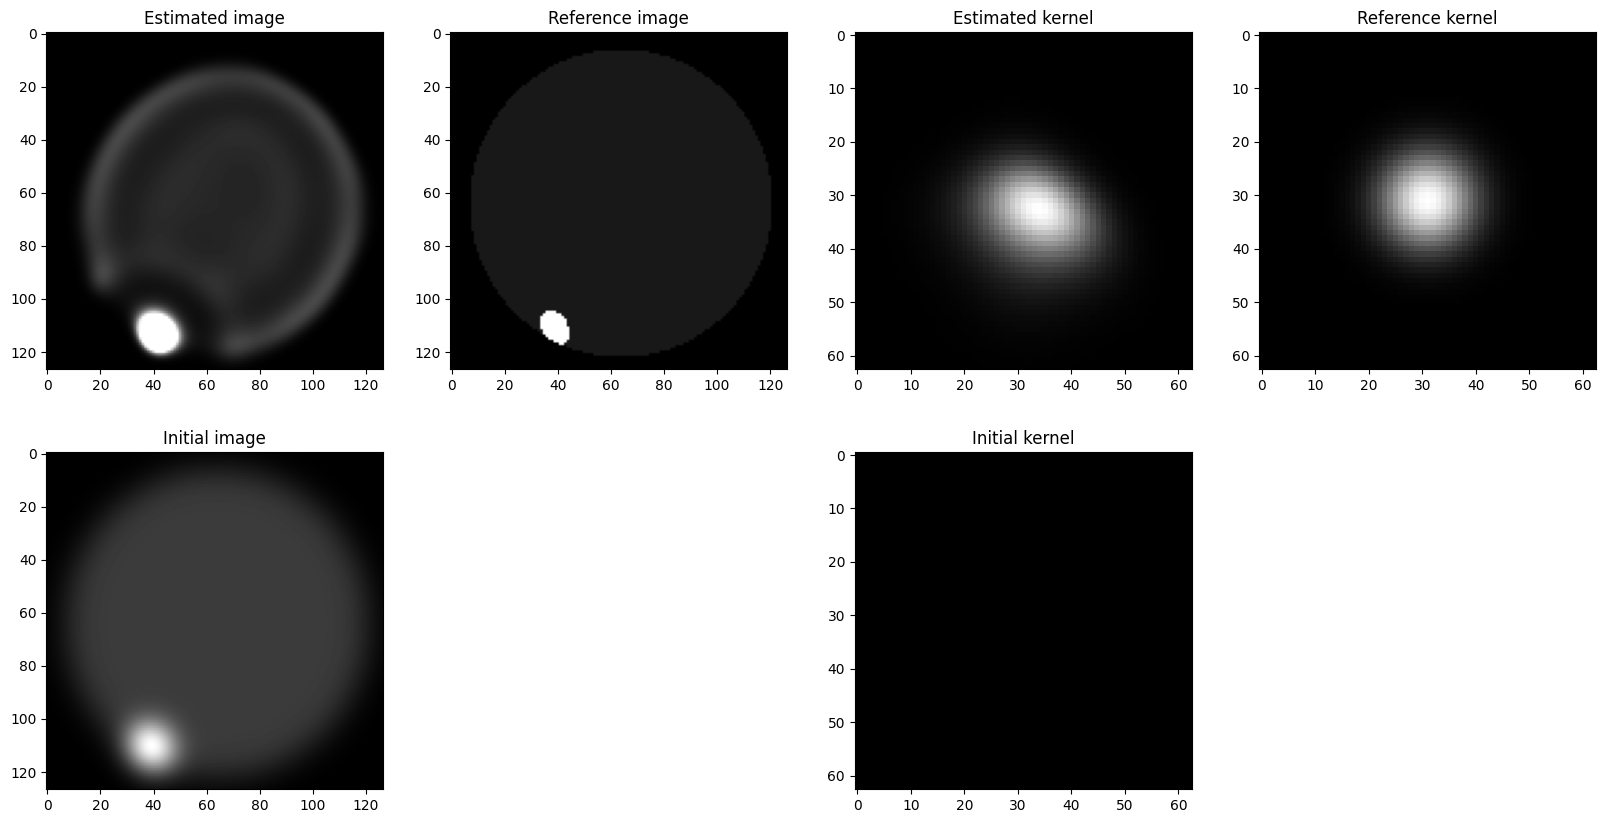

Step :  49


In [42]:
import torch.nn.functional as F
from IPython import display

# Different initializations for the image
# x_0 = torch.ones_like(y)
x_0 = y


# Different initializations for the kernel
gaussianblur = blur.GaussianBlur(k_size, 6.0).to(device)

# k_0 = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)
k_0 = torch.ones_like(k_ref) / torch.sum(torch.ones_like(k))
# k_0 = k

steps = 50
k_steps = 1
im_steps = 1

filter_epsilon = 1e-12
clip = True
observation = y
observation_L = torch.sum(observation, dim=1, keepdim=True)

with torch.no_grad():

    k = k_0.clone().float()
        
    im_deconv = x_0.clone().float()
    im_deconv_L = torch.sum(im_deconv, dim=1, keepdim=True)
    
    k_T = torch.flip(k, dims=[2, 3])  
    im_deconv_L_T = torch.flip(im_deconv_L, dims=[2, 3])
    
    eps = 1e-12
    pad_im = (k.size(2) // 2, k.size(2) // 2, k.size(3) // 2, k.size(3) // 2)
    pad_k = (im_deconv.size(2) // 2, im_deconv.size(2) // 2, im_deconv.size(3) // 2, im_deconv.size(3) // 2)
    
    for i in range(steps):
        
        # Display the image
        display.clear_output(wait=True)  # Clear the previous output

        plt.figure(figsize=(20, 10))
        plt.subplot(2, 4, 1)
        plt.imshow(im_deconv[0].permute(1, 2, 0).cpu().numpy(), cmap="gray")
        plt.title('Estimated image')
        plt.subplot(2, 4, 2)
        plt.imshow(ref[0].permute(1, 2, 0).cpu().numpy(), cmap="gray")
        plt.title('Reference image')
        plt.subplot(2, 4, 3)
        plt.imshow(k[0, 0].cpu().numpy(), cmap="gray")
        plt.title('Estimated kernel')
        plt.subplot(2, 4, 4)
        plt.imshow(k_ref[0, 0].cpu().numpy(), cmap="gray")
        plt.title('Reference kernel')
        plt.subplot(2, 4, 5)
        plt.imshow(x_0[0].permute(1, 2, 0).cpu().numpy(), cmap="gray")
        plt.title('Initial image')
        plt.subplot(2, 4, 7)
        plt.imshow(k_0[0, 0].cpu().numpy(), cmap="gray")
        plt.title('Initial kernel')
        plt.show()
        
        print("Step : ", i)
        
        # Kernel estimation
        # The issue with the offset is probably here, as there is no offset when using k as initialization
        
        for m in range(k_steps):      
            
            k = k.swapaxes(0, 1)
            conv11 = F.conv2d(F.pad(im_deconv_L, pad_im, mode='replicate'), k) + eps
            
            if filter_epsilon:
                relative_blur = torch.where(conv11 < filter_epsilon, 0.0, observation_L / conv11)
            else:
                relative_blur = observation_L / conv11
            
            k = k.swapaxes(0, 1)
            im_deconv_L_T = im_deconv_L_T.swapaxes(0, 1)
            im_mean = F.conv2d(torch.ones_like(F.pad(k, pad_k)), im_deconv_L_T)
            # im_mean = F.conv2d(F.pad(torch.ones_like(k), pad_k, mode='replicate'), im_deconv_T)
            
            if filter_epsilon:
                k = torch.where(im_mean < filter_epsilon, 0.0, k / im_mean)
            else:
                k /= im_mean

            conv12 = F.conv2d(F.pad(relative_blur, pad_k, mode='replicate'), im_deconv_L_T) + eps
            conv12 = conv12[:,:,
                        conv12.size(2) // 2 - k.size(2) // 2:conv12.size(2) // 2 + k.size(2) // 2 + 1,
                        conv12.size(3) // 2 - k.size(3) // 2:conv12.size(3) // 2 + k.size(3) // 2 + 1]
            k *= conv12
            k_T = torch.flip(k, dims=[2, 3]) 
        

        # For RGB images
        if(x_0.shape[1] == 3):
            k = k.repeat(1, 3, 1, 1)
            k_T = k_T.repeat(1, 3, 1, 1)
            groups = 3
        else:
            groups = 1
        # Image estimation

        for n in range(x_steps):
            
            k = k.swapaxes(0, 1)
            
            conv21 = F.conv2d(F.pad(im_deconv, pad_im, mode='replicate'), k, groups=groups) + eps
            
            if filter_epsilon:
                relative_blur = torch.where(conv21 < filter_epsilon, 0.0, observation / conv21)
            else:
                relative_blur = observation / conv21
            
            # k_mean = F.conv2d(F.pad(torch.ones_like(im_deconv), pad_im, mode='replicate'), k_T)
            k_T = k_T.swapaxes(0, 1)
            k_mean = F.conv2d(torch.ones_like(F.pad(im_deconv, pad_im)), k_T, groups=groups)
            if filter_epsilon:
                im_deconv = torch.where(k_mean < filter_epsilon, 0.0, im_deconv / k_mean)
            else:
                im_deconv /= k_mean
            
            im_deconv *= F.conv2d(F.pad(relative_blur, pad_im, mode='replicate'), k_T, groups=groups) + eps
            
            k_T = k_T.swapaxes(0, 1)
            k = k.swapaxes(0, 1)
        k = k[:, 0:1, :, :]
        k_T = k_T[:, 0:1, :, :]
        im_deconv_L = torch.sum(im_deconv, dim=1, keepdim=True)

        if clip:
            im_deconv = torch.clamp(im_deconv, 0, 1)
            
        im_deconv_T = torch.flip(im_deconv, dims=[2, 3])